In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.metrics import confusion_matrix
import pickle

In [2]:
import os
image_names = [ f.split('.')[0] for f in os.listdir('images') if f.endswith('.bmp') ]
image_filenames = { name: os.path.join('images', f"{name}.bmp") for name in image_names }

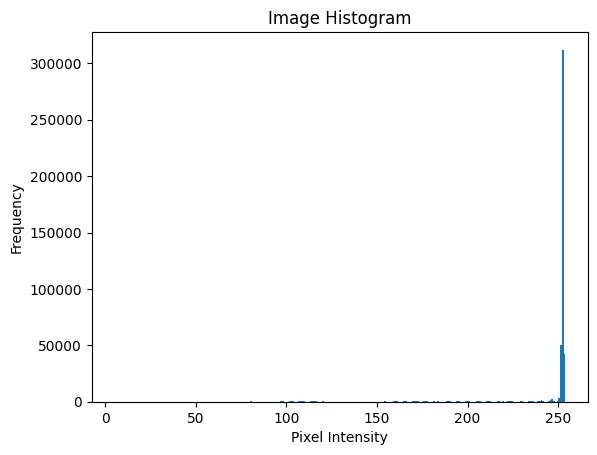

In [3]:
imgs = { name: cv2.imread(image_filenames[name], cv2.IMREAD_GRAYSCALE) for name in image_names }

plt.hist(imgs['a'].ravel(), 256)
plt.title('Image Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

From the hisogram above, we can see that a threshold around 240 should be fine for binarizing the images.

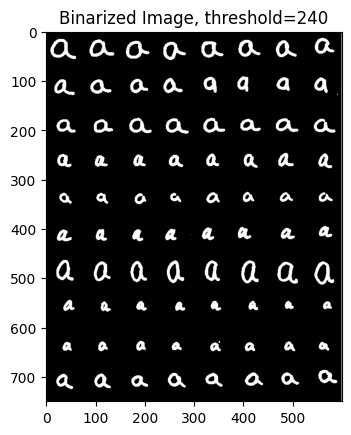

In [6]:
human_threshold = 240

# show image binarized with human threshold
_, thresh_img_human = cv2.threshold(imgs['a'], human_threshold, 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresh_img_human, cmap='gray')
plt.title(f'Binarized Image, threshold={human_threshold}')
plt.show()

Otsu threshold value: 192.0


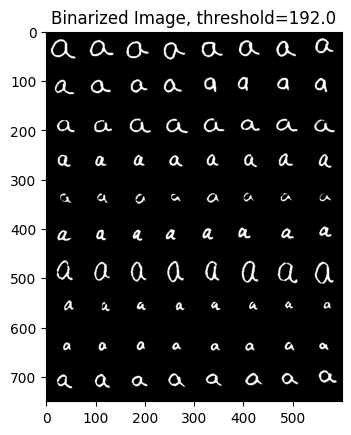

In [5]:
otsu_threshold, thresh_img = cv2.threshold(imgs['a'], 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
print(f"Otsu threshold value: {otsu_threshold}")
plt.imshow(thresh_img, cmap='gray')
plt.title(f'Binarized Image, threshold={otsu_threshold}')
plt.show()

We'll use the Otsu threshold value.

In [12]:
th_for_all = otsu_threshold
binarized_imgs = { name: cv2.threshold(imgs[name], th_for_all, 255, cv2.THRESH_BINARY_INV)[1] for name in image_names }

!! Small Component 38: Area=2, BBox=(562, 329, 2, 1)


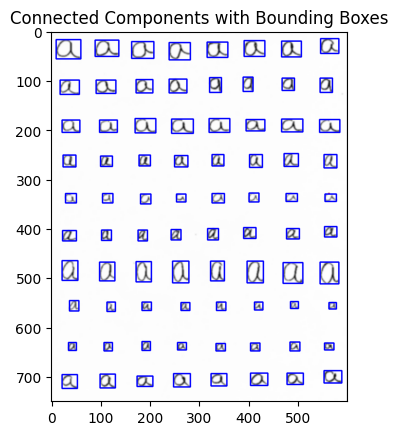

In [ ]:
labels = {name: cv2.connectedComponentsWithStats(binarized_imgs[name], connectivity=8) for name in image_names}
num_labels, label_map, stats, centroids = labels['a']

small_area_threshold = 50
small_areas = []

# draw bounding boxes around connected components
output_img = cv2.cvtColor(imgs['a'], cv2.COLOR_GRAY2BGR)
for i in range(1, num_labels):  # skip background
    x, y, w, h, area = stats[i]
    area_is_small = area < small_area_threshold
    if area_is_small:
        print(f"!! Small Component {i}: Area={area}, BBox=({x}, {y}, {w}, {h})")
        small_areas.append(i)
    cv2.rectangle(output_img, (x, y), (x + w, y + h), (255, 0, 0) if area_is_small else (0, 0, 255), 2)
plt.imshow(output_img)
plt.title('Connected Components with Bounding Boxes')

plt.show()

In [27]:
features = {}
for name in image_names:
    num_labels, label_map, stats, centroids = labels[name]
    features[name] = []
    for label in range(1, num_labels):
        x, y, w, h, area = stats[label]
        if area < small_area_threshold:
            continue
        roi = imgs['a'][y:y+h, x:x+w]
        moments = cv2.moments(roi)
        features[name].append(cv2.HuMoments(moments).flatten())

In [28]:
# save labels and features to pickle files
with open('labels.pkl', 'wb') as f:
    pickle.dump(labels, f)
with open('features.pkl', 'wb') as f:
    pickle.dump(features, f)

In [29]:
# load labels and features from pickle files
with open('labels.pkl', 'rb') as f:
    labels = pickle.load(f)
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)